In [ ]:
# extract features via librosa
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio = '/storageNVME/kcriss/gtr-145/gtr_55_333231/01.wav'
y, sr = librosa.load(audio)

# get stft of audio
stft = librosa.stft(y)

# extract mfcc
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# extract mel
mel = librosa.feature.melspectrogram(y=y, sr=sr)

# extract contrast
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

# extract spectral centroid
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)

# extract spectral bandwidth
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

# extract spectral rolloff
spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
spec_rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

# extract pitch(f0) from time series
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))
f0 = f0[np.newaxis, :]
voiced_flag = voiced_flag[np.newaxis, :]
voiced_probs = voiced_probs[np.newaxis, :]

times_f0 = librosa.times_like(f0)
# extract zero crossing rate
zcr = librosa.feature.zero_crossing_rate(y=y)

# extract flatness
flatness = librosa.feature.spectral_flatness(y=y)


In [9]:
# feature extractor class
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


class FeatureExtractor:
    def __init__(self, sr=22050):
        self.sr = sr

    def extract_features(self, audio_path):
        y, sr = librosa.load(audio_path, sr=self.sr)
        
        # extract mfcc
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

        # extract mel
        mel = librosa.feature.melspectrogram(y=y, sr=sr)

        # extract contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # extract spectral centroid
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)

        # extract spectral bandwidth
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

        # extract spectral rolloff
        spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
        spec_rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)

        # extract pitch(f0) from time series
        f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                                     fmin=librosa.note_to_hz('C2'),
                                                     fmax=librosa.note_to_hz('C7'))
        f0 = f0[np.newaxis, :]
        voiced_flag = voiced_flag[np.newaxis, :]
        voiced_probs = voiced_probs[np.newaxis, :]
        
        # extract zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y=y)
 
        # extract flatness
        flatness = librosa.feature.spectral_flatness(y=y)
        
        # concatenate all features
        # features = np.concatenate((mfcc, mel, contrast, spec_cent, spec_bw, spec_rolloff, spec_rolloff_min, f0, voiced_flag, voiced_probs, zcr, flatness), axis=0)
        features = np.concatenate((f0, voiced_probs), axis=0)
        # Aggregate features
        features = np.vstack((np.mean(features, axis=1))).flatten()
        
        return features

In [ ]:
import numpy as np
import librosa
import os
import re
from pprint import pprint
from natsort import natsorted
from tqdm import tqdm
import glob
import multiprocessing

base_folder_path = '/storageNVME/kcriss/gtr-145'

features_folder_path = f'{base_folder_path}-features'
if not os.path.exists(features_folder_path):
    os.makedirs(features_folder_path)
    
# get all the folders under the base folder
wav_files = natsorted(glob.glob(os.path.join(base_folder_path, '**/*.wav'), recursive=True))

wav_files_no_0_labels = [
    wav_file for wav_file in wav_files
    if not (int(re.findall(r'\d+', wav_file)[-2][-3]) == 0 or int(re.findall(r'\d+', wav_file)[-2][-1]) == 0)
]

labels_G = []
labels_T = []
labels_R = []
features = []

def process_file(wav_file):
    # 从文件路径中提取数字
    digits = re.findall(r'\d+', wav_file)[-2]
    try:
        G = int(digits[-3])
        T = int(digits[-2])
        R = int(digits[-1])

        # 提取特征
        extractor = FeatureExtractor()
        feature = extractor.extract_features(audio_path=wav_file)

        feature_file_path = os.path.join(features_folder_path, os.path.basename(wav_file) + '.npy')
        # np.save(feature_file_path, feature)  # 保存特征到文件

        return (G, T, R, feature, f'Processed {wav_file}_G{G}_T{T}_R{R}')
    except Exception as e:
        return None, None, None, None, f"Error processing {wav_file}: {e}"

with multiprocessing.Pool() as pool:
    results = list(tqdm(pool.imap(process_file, wav_files), total=len(wav_files)))

for G, T, R, feature, message in results:
    if feature is not None:
        labels_G.append(G)
        labels_T.append(T)
        labels_R.append(R)
        features.append(feature)
        print(message)
    else:
        print(message)
            
features = np.array(features)
labels_G = np.array(labels_G)
labels_T = np.array(labels_T)
labels_R = np.array(labels_R)



In [33]:
features.shape
# labels_G.shape

(165, 2)

In [45]:
labels_G

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [34]:
features = np.nan_to_num(features, nan=0.0)
features[~np.isfinite(features)] = 0

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features, labels_R, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# check mean and std of the scaled features
print(f'Mean of the scaled features: {np.mean(X_train_scaled)}')
print(f'Std of the scaled features: {np.std(X_train_scaled)}')


Mean of the scaled features: -2.6914497566670462e-17
Std of the scaled features: 0.7071067811865476


In [39]:
print(X_train_scaled.shape, y_train.shape)

(132, 2) (132,)


In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

clf = make_pipeline(SVC(gamma=100, C=0.1, kernel='sigmoid'))
clf.fit(X_train_scaled, y_train)

Pipeline(steps=[('svc', SVC(C=0.1, gamma=100, kernel='sigmoid'))])

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
Best score: 0.37948717948717947


In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 在训练集上评估模型
y_train_pred = clf.predict(X_train)
print("Train set report:")
print(classification_report(y_train, y_train_pred))

# 在测试集上进行预测
y_test_pred = clf.predict(X_test)

# 测试集评估
print("Test set report:")
print(classification_report(y_test, y_test_pred))

# plot loss curve
# plt.plot(clf[-1].loss_curve_)


Train set report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        17
           3       0.13      1.00      0.23        17
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        15

    accuracy                           0.13       132
   macro avg       0.02      0.12      0.03       132
weighted avg       0.02      0.13      0.03       132

Test set report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.09      1.00      0.17         3
           4       0.00      0.00      0.00

/home/kcriss/.conda/envs/artivoice/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kcriss/.conda/envs/artivoice/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kcriss/.conda/envs/artivoice/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [ ]:
# print all features shape
print('y: ', y.shape)
print('stft: ', stft.shape)
print('mfcc: ', mfcc.shape)
print('mel: ', mel.shape)
print('contrast: ', contrast.shape)
print('spectral centroid: ', spec_cent.shape)
print('spectral bandwidth: ', spec_bw.shape)
print('spectral rolloff: ', spec_rolloff.shape)
print('spectral rolloff min: ', spec_rolloff_min.shape)
print('f0: ', f0.shape)
print('voiced flag: ', voiced_flag.shape)
print('voiced probs: ', voiced_probs.shape) 
print('zero crossing rate: ', zcr.shape)
print('flatness: ', flatness.shape)

y:  (133207,)
stft:  (1025, 261)
mfcc:  (40, 261)
mel:  (128, 261)
contrast:  (7, 261)
spectral centroid:  (1, 261)
spectral bandwidth:  (1, 261)
spectral rolloff:  (1, 261)
spectral rolloff min:  (1, 261)
f0:  (1, 261)
voiced flag:  (1, 261)
voiced probs:  (1, 261)
zero crossing rate:  (1, 261)
flatness:  (1, 261)


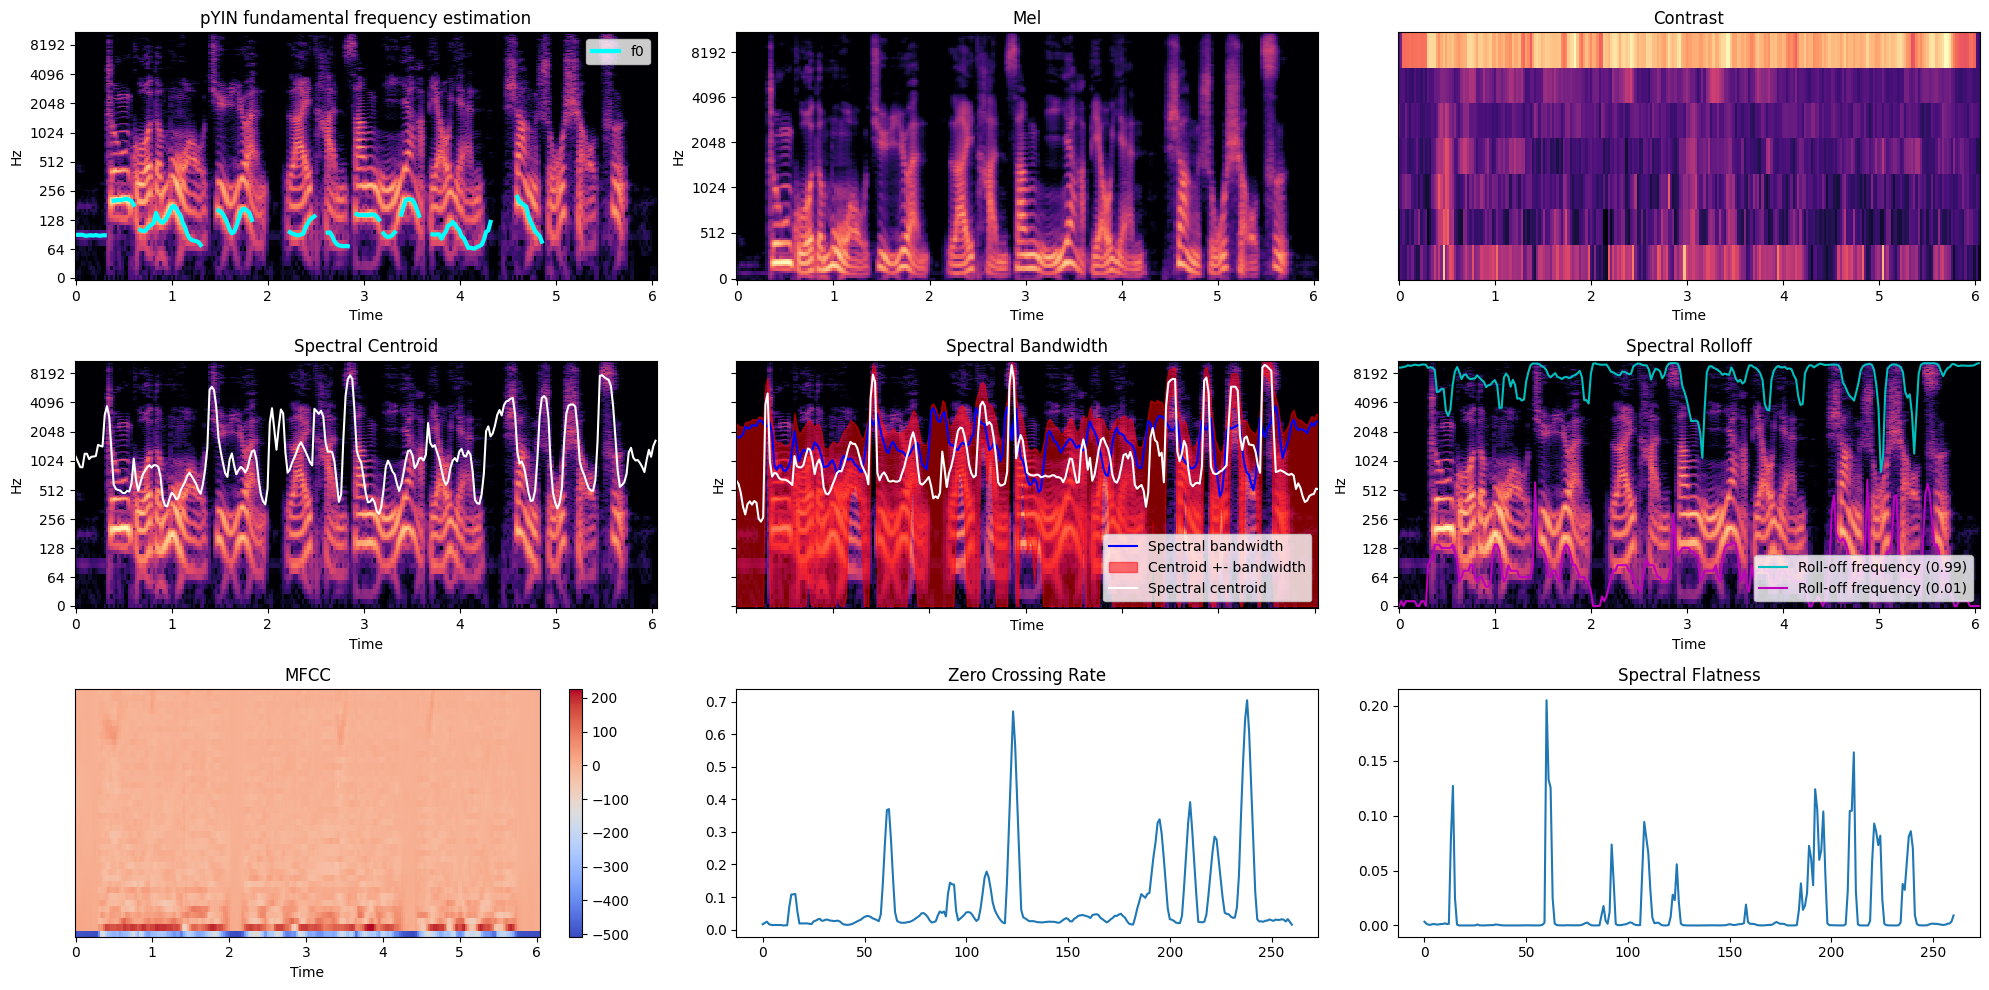

In [ ]:
# plot all features

# mfcc
plt.figure(figsize=(20, 10))
plt.subplot(3, 3, 7)  # Change from (2, 4, 1) to (3, 3, 1)
librosa.feature.mfcc(S=librosa.power_to_db(mel))

librosa.display.specshow(mfcc, x_axis='time')

plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# mel spectrogram
plt.subplot(3, 3, 2)  # Change from (2, 4, 2) to (3, 3, 2)
ax = plt.gca()
S_dB = librosa.power_to_db(mel, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=sr/2, ax=ax)
plt.title('Mel')
plt.tight_layout()

# contrast
plt.subplot(3, 3, 3)  # Change from (2, 4, 3) to (3, 3, 3)
librosa.display.specshow(contrast, x_axis='time')
plt.title('Contrast')
# plt.colorbar()
plt.tight_layout()

# spectral centroid
plt.subplot(3, 3, 4)  # Change from (2, 4, 4) to (3, 3, 4)
ax = plt.gca() # get current axis
S, phase = librosa.magphase(librosa.stft(y=y))
times = librosa.times_like(spec_cent)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, spec_cent[0], label='Spectral centroid', color='w')
plt.title('Spectral Centroid')
# plt.colorbar()
plt.tight_layout()

# spectral bandwidth
plt.subplot(3, 3, 5)  # Change from (2, 4, 5) to (3, 3, 5)
ax = plt.gca()  # 获取当前的Axes对象

# band width
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=mel)
ax.semilogy(times, spec_bw[0], label='Spectral bandwidth', color='b')  
ax.set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax.legend()
ax.label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)

ax.fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                np.minimum(centroid[0] + spec_bw[0], sr/2),
                alpha=0.5, label='Centroid +- bandwidth', color='r')  
ax.plot(times, centroid[0], label='Spectral centroid', color='w')
ax.legend(loc='lower right')
plt.title('Spectral Bandwidth')

# spectral rolloff
plt.subplot(3, 3, 6)  # Change from (2, 4, 6) to (3, 3, 6)
ax = plt.gca()  # 获取当前的Axes对象
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(librosa.times_like(spec_rolloff), spec_rolloff[0], label='Roll-off frequency (0.99)', color='c')
ax.plot(librosa.times_like(spec_rolloff), spec_rolloff_min[0], color='m', label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
plt.title('Spectral Rolloff')

# pitch
plt.subplot(3, 3, 1)  # Change from (2, 4, 7) to (3, 3, 7)
ax = plt.gca()
times_f0 = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)S
librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
ax.plot(times_f0, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

# zero crossing rate
plt.subplot(3, 3, 8)  # Change from (2, 4, 8) to (3, 3, 8)
plt.plot(zcr[0])
plt.title('Zero Crossing Rate')
plt.tight_layout()

# flatness
plt.subplot(3, 3, 9)  # Add new subplot (3, 3, 9)
plt.plot(flatness[0])
plt.title('Spectral Flatness')
plt.tight_layout()

plt.show()